# Q1. For a given dataset (e.g. iris data set) D of size N×M with N:Number of samples and M: number of features, design a Bayesian classifier/ Support vector machine/ Decision tree  to classify the test data. Divide the data set into training or testing data according to random percentage split. (Assume the underlying distribution to Gaussian).

Accuracy (Bayesian): 1.0
Accuracy (SVM): 0.6666666666666666
Accuracy (Decision Tree): 1.0


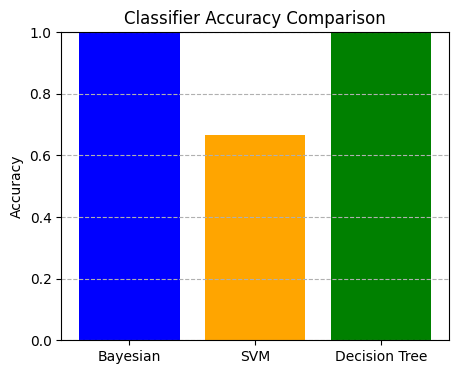

In [6]:
import numpy as np
import csv
import matplotlib.pyplot as plt  # Import Matplotlib for plotting

# Function to load data from a CSV file and skip the header
def load_csv(filename):
    data = []
    labels = []
    with open(filename, 'r') as file:
        csvreader = csv.reader(file)
        next(csvreader)  # Skip the header row
        for row in csvreader:
            data.append(row[:-1])  # All columns except the last (features)
            labels.append(row[-1])  # Last column (label)
    return np.array(data, dtype=float), np.array(labels)

# Load the dataset
filename = 'Iris.csv'  # Replace with the path to your CSV file
X, y = load_csv(filename)

# Convert string labels to integers
label_mapping = {label: idx for idx, label in enumerate(np.unique(y))}
y = np.array([label_mapping[label] for label in y])

# Split the data into training and testing sets (80% training, 20% testing)
def train_test_split(X, y, test_size=0.2):
    np.random.seed(42)
    indices = np.random.permutation(len(X))
    test_size = int(len(X) * test_size)
    test_indices = indices[:test_size]
    train_indices = indices[test_size:]
    return X[train_indices], X[test_indices], y[train_indices], y[test_indices]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Bayesian Classifier (Naive Bayes)
def gaussian_probability(x, mean, var):
    eps = 1e-9  # To avoid division by zero
    coefficient = 1.0 / np.sqrt(2.0 * np.pi * (var + eps))
    exponent = np.exp(- ((x - mean) ** 2) / (2 * (var + eps)))
    return coefficient * exponent

class NaiveBayes:
    def fit(self, X, y):
        self.classes = np.unique(y)
        self.mean = np.zeros((len(self.classes), X.shape[1]), dtype=np.float64)
        self.var = np.zeros((len(self.classes), X.shape[1]), dtype=np.float64)
        self.prior = np.zeros(len(self.classes), dtype=np.float64)
        
        for idx, c in enumerate(self.classes):
            X_c = X[y == c]
            self.mean[idx, :] = np.mean(X_c, axis=0)
            self.var[idx, :] = np.var(X_c, axis=0)
            self.prior[idx] = X_c.shape[0] / X.shape[0]
    
    def predict(self, X):
        y_pred = [self._predict_single(x) for x in X]
        return np.array(y_pred)
    
    def _predict_single(self, x):
        posteriors = []
        
        for idx, c in enumerate(self.classes):
            prior = np.log(self.prior[idx])
            class_conditional = np.sum(np.log(gaussian_probability(x, self.mean[idx, :], self.var[idx, :])))
            posterior = prior + class_conditional
            posteriors.append(posterior)
        
        return self.classes[np.argmax(posteriors)]

# Train and test Naive Bayes classifier
nb_classifier = NaiveBayes()
nb_classifier.fit(X_train, y_train)
y_pred_bayes = nb_classifier.predict(X_test)

# Accuracy
accuracy_bayes = np.sum(y_pred_bayes == y_test) / len(y_test)
print("Accuracy (Bayesian):", accuracy_bayes)

# SVM Classifier
class SVM:
    def __init__(self, learning_rate=0.001, lambda_param=0.01, n_iters=1000):
        self.lr = learning_rate
        self.lambda_param = lambda_param
        self.n_iters = n_iters
        self.w = None
        self.b = None

    def fit(self, X, y):
        n_samples, n_features = X.shape
        y_ = np.where(y <= 0, -1, 1)

        self.w = np.zeros(n_features)
        self.b = 0

        for _ in range(self.n_iters):
            for idx, x_i in enumerate(X):
                condition = y_[idx] * (np.dot(x_i, self.w) - self.b) >= 1
                if condition:
                    self.w -= self.lr * (2 * self.lambda_param * self.w)
                else:
                    self.w -= self.lr * (2 * self.lambda_param * self.w - np.dot(x_i, y_[idx]))
                    self.b -= self.lr * y_[idx]

    def predict(self, X):
        approx = np.dot(X, self.w) - self.b
        return np.sign(approx)

# Convert labels for binary classification (0 vs 1)
y_binary = np.where(y_train == 0, 0, 1)
y_test_binary = np.where(y_test == 0, 0, 1)

# Train and test SVM
svm_classifier = SVM()
svm_classifier.fit(X_train, y_binary)
y_pred_svm = svm_classifier.predict(X_test)

# Accuracy
accuracy_svm = np.sum(y_pred_svm == y_test_binary) / len(y_test_binary)
print("Accuracy (SVM):", accuracy_svm)

# Decision Tree Classifier
class DecisionTree:
    def __init__(self, max_depth=10):
        self.max_depth = max_depth
        self.tree = None

    def fit(self, X, y):
        self.tree = self._grow_tree(X, y)

    def _grow_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        n_labels = len(np.unique(y))

        if depth >= self.max_depth or n_labels == 1 or n_samples == 0:
            leaf_value = self._most_common_label(y)
            return leaf_value

        feat_idxs = np.random.choice(n_features, n_features, replace=False)

        best_feat, best_thresh = self._best_criteria(X, y, feat_idxs)
        left_idxs, right_idxs = self._split(X[:, best_feat], best_thresh)

        left = self._grow_tree(X[left_idxs, :], y[left_idxs], depth + 1)
        right = self._grow_tree(X[right_idxs, :], y[right_idxs], depth + 1)

        return (best_feat, best_thresh, left, right)

    def _best_criteria(self, X, y, feat_idxs):
        best_gain = -1
        split_idx, split_thresh = None, None

        for feat_idx in feat_idxs:
            X_column = X[:, feat_idx]
            thresholds = np.unique(X_column)

            for threshold in thresholds:
                gain = self._information_gain(y, X_column, threshold)

                if gain > best_gain:
                    best_gain = gain
                    split_idx = feat_idx
                    split_thresh = threshold

        return split_idx, split_thresh

    def _information_gain(self, y, X_column, split_thresh):
        parent_entropy = self._gini(y)

        left_idxs, right_idxs = self._split(X_column, split_thresh)

        if len(left_idxs) == 0 or len(right_idxs) == 0:
            return 0

        n = len(y)
        n_left, n_right = len(left_idxs), len(right_idxs)
        e_left, e_right = self._gini(y[left_idxs]), self._gini(y[right_idxs])
        child_entropy = (n_left / n) * e_left + (n_right / n) * e_right

        return parent_entropy - child_entropy

    def _gini(self, y):
        proportions = np.bincount(y.astype(int)) / len(y)
        return 1 - np.sum(proportions ** 2)

    def _split(self, X_column, split_thresh):
        left_idxs = np.argwhere(X_column <= split_thresh).flatten()
        right_idxs = np.argwhere(X_column > split_thresh).flatten()
        return left_idxs, right_idxs

    def _most_common_label(self, y):
        return np.bincount(y.astype(int)).argmax()

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.tree) for x in X])

    def _traverse_tree(self, x, tree):
        if not isinstance(tree, tuple):
            return tree

        feature_idx, threshold, left, right = tree

        if x[feature_idx] <= threshold:
            return self._traverse_tree(x, left)
        else:
            return self._traverse_tree(x, right)

# Train and test Decision Tree
tree_classifier = DecisionTree(max_depth=3)
tree_classifier.fit(X_train, y_train)
y_pred_tree = tree_classifier.predict(X_test)

# Accuracy
accuracy_tree = np.sum(y_pred_tree == y_test) / len(y_test)
print("Accuracy (Decision Tree):", accuracy_tree)

# Plotting the accuracy results
accuracy_list = [accuracy_bayes, accuracy_svm, accuracy_tree]
classifiers = ['Bayesian', 'SVM', 'Decision Tree']

plt.figure(figsize=(5, 4))
plt.bar(classifiers, accuracy_list, color=['blue', 'orange', 'green'])
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.title('Classifier Accuracy Comparison')
plt.grid(axis='y', linestyle='--')
plt.show()
